In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import matplotlib.pyplot as plt
import os
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  

In [3]:
file_path = '期货.xlsx'

#清洗数据
#前两行
df_header = pd.read_excel(file_path, header=None, nrows=2)

#合并前两行
new_columns = []
for col1, col2 in zip(df_header.iloc[0], df_header.iloc[1]):
    #处理空值
    col1_str = str(col1).strip() if pd.notna(col1) else ''
    col2_str = str(col2).strip() if pd.notna(col2) else ''
    new_col = f"{col1_str}_{col2_str}".strip('_')
    new_columns.append(new_col)

#从第3行开始读数据
df = pd.read_excel(file_path, header=[2])
df.columns = new_columns  #替换合成列名


In [3]:
#保留“日期”
date_cols = [col for col in df.columns if '日期' in str(col)]

#保留“收盘价”
close_cols = [col for col in df.columns if str(col).strip().endswith('_收盘价')]

# 最终保留的列
keep_cols = date_cols + close_cols
df_filtered = df[keep_cols].copy()

# 保存结果
df_filtered.to_excel("期货收盘价.xlsx", index=False)

In [2]:
OBS_VAR = 0.01
STATE_VAR = 0.0001
INIT_MEAN = 1.0
INIT_VAR = 1.0
WIN = 60
OPEN_H = 2.0
OPEN_L = -2.0
CLOSE_H = 0.5
CLOSE_L = -0.5
STOP_SPREAD = 3.0
MAX_HOLD = 10

In [3]:
df = pd.read_excel("期货收盘价.xlsx")
df['datetime'] = pd.to_datetime(df['日期'])
df = df.sort_values("datetime").reset_index(drop=True)

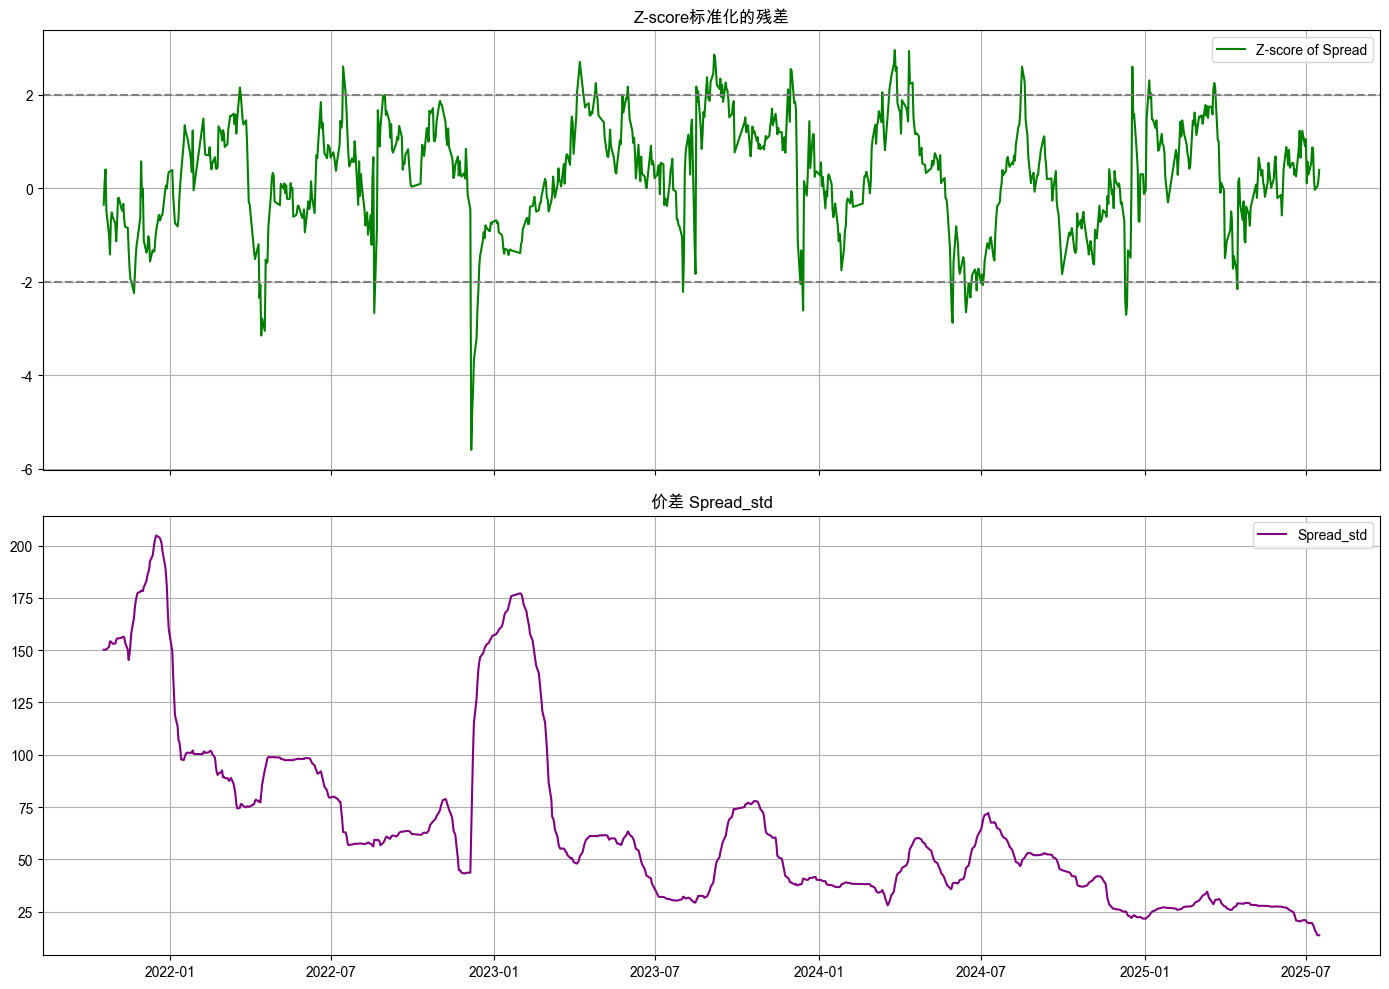

In [4]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False

@njit
def kalman_filter_numba(py, px, obs_var, state_var, init_mean, init_var):
    n = len(py)
    betas = np.zeros(n)
    spreads = np.zeros(n)

    state_mean = init_mean
    state_var_ = init_var

    for i in range(n):
        pred_mean = state_mean
        pred_var = state_var_ + state_var
        k_gain = pred_var / (pred_var * px[i]**2 + obs_var)
        state_mean = pred_mean + k_gain * (py[i] - pred_mean * px[i])
        state_var_ = (1 - k_gain * px[i]) * pred_var

        betas[i] = state_mean
        spreads[i] = py[i] - state_mean * px[i]

    return betas, spreads

"""
这里用numba优化了一下，准备看看跑的情况
"""
py = df['焦煤主连_收盘价'].values.astype(np.float64)
px = df['焦炭主连_收盘价'].values.astype(np.float64)
    
betas, spreads = kalman_filter_numba(
    py, px, OBS_VAR, STATE_VAR, INIT_MEAN, INIT_VAR
)

df['beta_kalman'] = betas
df['spread'] = spreads
df['spread_mean'] = df['spread'].rolling(WIN).mean()
df['spread_std'] = df['spread'].rolling(WIN).std()
df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

#画图看看
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df['datetime'], df['zscore'], label='Z-score of Spread', color='green')
axes[0].axhline(2, linestyle='--', color='gray')
axes[0].axhline(-2, linestyle='--', color='gray')
axes[0].set_title("Z-score标准化的残差")
axes[0].legend()
axes[0].grid()

axes[1].plot(df['datetime'], df['spread_std'], label='Spread_std', color='purple')
axes[1].set_title("价差 Spread_std")
axes[1].legend()
axes[1].grid()
    
plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler

def train_hmm_on_beta_vol_and_plot(
    df,
    beta_col='beta_kalman',
    zscore_col='zscore',
    time_col='datetime',
    window=60,
    n_states=3,
    vol_col='beta_vol',
    state_col='beta_state'
):
    """
    对 beta 的波动率进行建模 + HMM regime 拟合 + 状态可视化（强化初始状态设定）
    """
    df = df.copy()

    # Step 1：计算 beta_vol（rolling std）+ log + 标准化
    df[vol_col] = df[beta_col].rolling(window=window, min_periods=10).std()
    df[vol_col] = np.log(df[vol_col] + 1e-9)
    df = df.dropna(subset=[vol_col, zscore_col])

    # 组合观测变量
    obs = np.column_stack([df[vol_col].values, df[zscore_col].values])
    scaler = StandardScaler()
    obs_scaled = scaler.fit_transform(obs)
    
    # Step 2：构建 HMM + 初始化参数（强引导）
    model = GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        init_params="",  # 不再随机初始化 means, covars
        random_state=42
    )

    # 设置初始状态概率
    model.startprob_ = np.array([1.0 / n_states] * n_states)
    # 强引导转移矩阵（增加状态持续性）
    model.transmat_ = np.array([
        [0.94, 0.04, 0.02],
        [0.04, 0.92, 0.04],
        [0.02, 0.04, 0.94]
    ])
    
    # 设置初始状态均值（标准化后的经验值）
    model.means_ = np.array([
        [-1.5, -1.0],
        [0.0, 0.0],
        [1.5, 1.0]
    ])
    
    # 设置协方差
    model.covars_ = np.tile(np.identity(2) * 2.0, (n_states, 1, 1))

    # Step 3：拟合模型
    model.fit(obs_scaled)
    hidden_states = model.predict(obs_scaled)

    # Step 5：排序状态（按 beta_vol 分布）
    vol_means = model.means_[:, 0]
    state_order = np.argsort(vol_means)
    mapping = {original: new for new, original in enumerate(state_order)}
    mapped_states = np.array([mapping[s] for s in hidden_states])
    df[state_col] = mapped_states

    # Step 5：绘图（beta_vol + regime）
    times = df[time_col]
    beta_vol_plot = df[vol_col]
    states = df[state_col]

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(times, beta_vol_plot, label='Beta Volatility (log)', color='black', linewidth=1.2)
    ax1.set_ylabel('Log Beta Volatility (black)')
    ax1.set_xlabel('Time')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.step(times, states, label='HMM State', color='red', linewidth=1.2, where='post', alpha=0.6)
    ax2.set_ylabel('HMM State (red)')
    ax2.set_ylim(-0.1, n_states - 0.9)
    ax2.set_yticks(range(n_states))
    ax2.set_yticklabels(['Low', 'Med', 'High'][:n_states])

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=30)
    plt.title('Beta Volatility (log) & Z-score with 3-State HMM Regime')
    fig.tight_layout()
    plt.show()

    return df, model

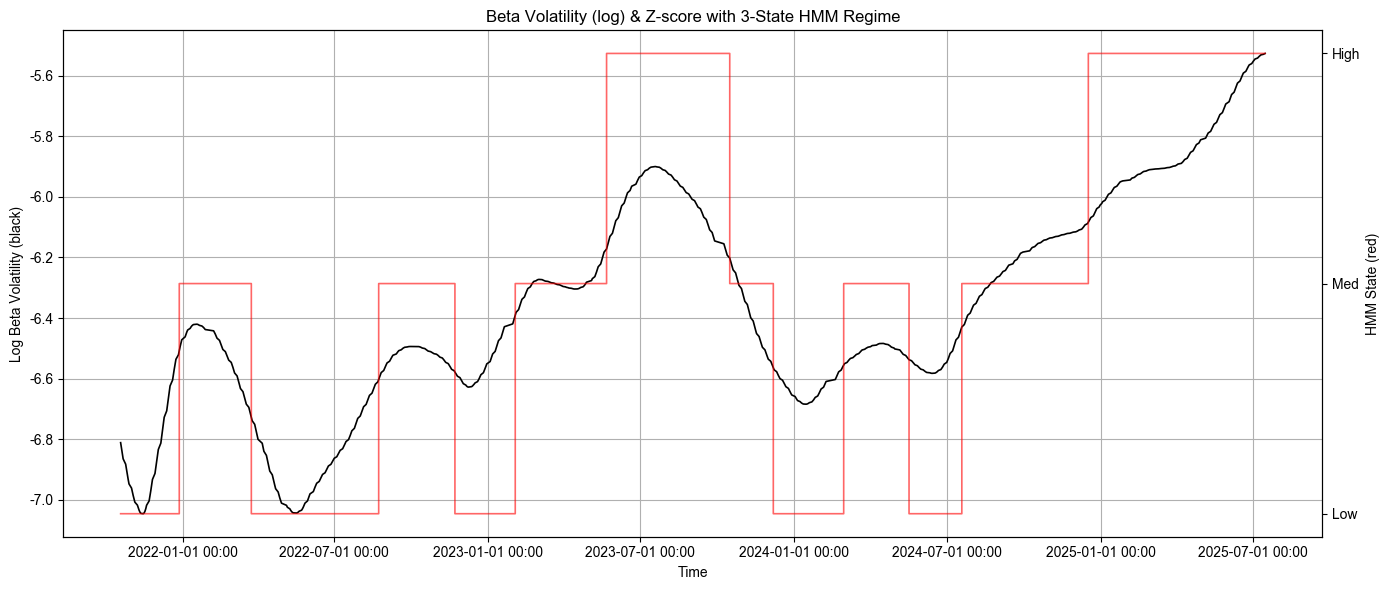

(            日期  螺纹钢主连_收盘价  焦煤主连_收盘价  焦炭主连_收盘价  铁矿石主连_收盘价  热卷主连_收盘价   datetime  \
 59  2021-10-19       5546    3729.0    4402.0      707.0      5736 2021-10-19   
 60  2021-10-20       5304    3441.5    4039.0      710.0      5550 2021-10-20   
 61  2021-10-21       4976    3109.0    3663.5      650.5      5268 2021-10-21   
 62  2021-10-22       4900    2875.0    3564.0      689.5      5308 2021-10-22   
 63  2021-10-25       4825    2970.5    3741.0      688.5      5180 2021-10-25   
 ..         ...        ...       ...       ...        ...       ...        ...   
 963 2025-07-10       3123     897.0    1497.0      763.5      3262 2025-07-10   
 964 2025-07-11       3133     913.0    1519.5      764.0      3273 2025-07-11   
 965 2025-07-14       3138     920.0    1525.0      766.5      3276 2025-07-14   
 966 2025-07-15       3114     911.5    1514.0      767.0      3259 2025-07-15   
 967 2025-07-16       3106     897.0    1494.5      773.0      3253 2025-07-16   
 
      beta_kal

In [12]:
train_hmm_on_beta_vol_and_plot(df)

In [27]:
def generate_signal_with_frozen_beta_vol(
    df,
    z_col='zscore',
    beta_col='beta_kalman',
    beta_vol_col='beta_vol',
    time_col='datetime',
    #参数
    base_open_h= 2.0,
    base_open_l=-2.0,
    alpha=5.0,
    beta_vol_window=60,
    close_h= 0.5,
    close_l=-0.5,
    stop_spread=1.5,
    start_index = None
):
    """
    交易信号+冻结beta+平仓后刷新beta，
    signal: 1=多Y空X，-1=空Y多X，0=空仓
    frozen_beta: 信号触发时冻结，平仓后立即刷新，空仓期间保持刷新后的beta
    """
    df = df.copy()
    df['beta_vol'] = df[beta_col].rolling(window=beta_vol_window, min_periods=10).std()
    n = len(df)
    df['signal'] = 0
    df['frozen_beta'] = np.nan

    position = 0
    entry_z = None
    entry_time = None
    frozen_beta = None
    start_i = start_index if start_index is not None else 0

    for i in range(start_i, n):
        z = df.at[df.index[i], z_col]
        t = df.at[df.index[i], time_col]
        beta_now = df.at[df.index[i], beta_col]
        beta_vol = df.at[df.index[i], 'beta_vol']
        #动态门槛
        open_h = base_open_h + alpha * beta_vol if pd.notnull(beta_vol) else base_open_h
        open_l = base_open_l - alpha * beta_vol if pd.notnull(beta_vol) else base_open_l

        if position == 0:
            #空仓：找开仓信号
            if z < open_l:
                position = 1
                entry_z = z
                entry_time = t
                frozen_beta = beta_now if np.isfinite(beta_now) else 1.0
                df.at[df.index[i], 'signal'] = 1
            elif z > open_h:
                position = -1
                entry_z = z
                entry_time = t
                frozen_beta = beta_now if np.isfinite(beta_now) else 1.0
                df.at[df.index[i], 'signal'] = -1
            else:
                #空仓：使用上一次更新的frozen_beta
                frozen_beta = beta_now if np.isfinite(beta_now) else frozen_beta
                df.at[df.index[i], 'signal'] = 0

        else:
            #持仓中：判断平仓条件
            profit_cond = (close_l < z < close_h)
            stop_cond = ((position == 1 and z < entry_z - stop_spread) or
                         (position == -1 and z > entry_z + stop_spread))

            if profit_cond or stop_cond:
                #平仓并刷新frozen_beta
                frozen_beta = beta_now if np.isfinite(beta_now) else frozen_beta
                df.iloc[i, df.columns.get_loc('signal')] = 0
                position = 0
                entry_z = None
                entry_time = None
                frozen_beta = beta_now if np.isfinite(beta_now) else frozen_beta
                df.at[df.index[i], 'signal'] = 0
            else:
                df.at[df.index[i], 'signal'] = position

        #写入frozen_beta（持仓中保持锁定，空仓中已更新）
        df.at[df.index[i], 'frozen_beta'] = frozen_beta

    return df


In [43]:
def generate_signal_with_beta_drift_buffer_and_weighted_z(
    df,
    z_col='zscore',
    beta_col='beta_kalman',
    time_col='datetime',
    base_open_h=2.0,
    base_open_l=-2.0,
    alpha=5.0,
    close_h=0.5,
    close_l=-0.5,
    stop_spread=1.5,
    beta_diff_base_tol=0.01,
    beta_diff_alpha_z=0.01,
    z_weight_gamma=3.0,
    start_index=None
):
    """
    增强版本交易信号生成器，融合：
    1. 冻结 beta 并基于其动态偏离容忍区间控制平仓
    2. zscore 根据 beta 偏离程度调整强度

    参数说明：
    - base_open_h / base_open_l: 基础开仓门槛
    - alpha: beta_diff 越大，门槛越高（增强过滤）
    - beta_diff_base_tol: beta_diff 基础容忍比例（如 1%）
    - beta_diff_alpha_z: 容忍区间随 z 绝对值增加
    - z_weight_gamma: beta_diff 对 z 的压缩强度
    """
    df = df.copy()
    n = len(df)
    df['signal'] = 0
    df['frozen_beta'] = np.nan
    df['z_adj'] = np.nan

    position = 0
    entry_z = None
    entry_time = None
    frozen_beta = None
    start_i = start_index if start_index is not None else 0

    for i in range(start_i, n):
        z = df.at[df.index[i], z_col]
        t = df.at[df.index[i], time_col]
        beta_now = df.at[df.index[i], beta_col]

        # 计算 beta 漂移比例
        beta_diff_ratio = abs(beta_now - frozen_beta) / frozen_beta if frozen_beta else 0

        # 容忍区间设置（随 zscore 增大而放松）
        beta_tol = beta_diff_base_tol + beta_diff_alpha_z * abs(z)

        # zscore 权重修正
        z_adj = z / (1 + z_weight_gamma * beta_diff_ratio) if frozen_beta else z
        df.at[df.index[i], 'z_adj'] = z_adj

        # 动态开仓门槛（可选增强）
        open_h = base_open_h + alpha * beta_diff_ratio
        open_l = base_open_l - alpha * beta_diff_ratio

        if position == 0:
            if z_adj < open_l:
                position = 1
                entry_z = z_adj
                entry_time = t
                frozen_beta = beta_now if np.isfinite(beta_now) else 1.0
                df.at[df.index[i], 'signal'] = 1
            elif z_adj > open_h:
                position = -1
                entry_z = z_adj
                entry_time = t
                frozen_beta = beta_now if np.isfinite(beta_now) else 1.0
                df.at[df.index[i], 'signal'] = -1
            else:
                # 空仓期继续刷新 beta
                frozen_beta = beta_now if np.isfinite(beta_now) else frozen_beta
                df.at[df.index[i], 'signal'] = 0

        else:
            # 判断平仓条件
            profit_cond = (close_l < z_adj < close_h)
            stop_cond = ((position == 1 and z_adj < entry_z - stop_spread) or
                         (position == -1 and z_adj > entry_z + stop_spread))
            beta_drift_cond = beta_diff_ratio > beta_tol

            if profit_cond or stop_cond or beta_drift_cond:
                frozen_beta = beta_now if np.isfinite(beta_now) else frozen_beta
                df.at[df.index[i], 'signal'] = 0
                position = 0
                entry_z = None
                entry_time = None
            else:
                df.at[df.index[i], 'signal'] = position

        # 记录 frozen_beta
        df.at[df.index[i], 'frozen_beta'] = frozen_beta

    return df

In [44]:
df = generate_signal_with_beta_drift_buffer_and_weighted_z(df)

In [45]:
def calculate_pair_strategy_returns(
    df, 
    price_y='焦煤主连_收盘价', 
    price_x='焦煤主连_收盘价', 
    beta_col='beta_kalman', 
    signal_col='signal',
    time_col='datetime',
    freeze_beta=True,
):
    """
    计算配对策略组合收益，并绘制持仓图与收益图
    开仓时冻结 beta，持仓期保持不变
    """
    df = df.copy()

    #生成 position
    df['position'] = df[signal_col].shift(1).fillna(0)

    #冻结 beta
    if freeze_beta:
        frozen_beta = []
        current_beta = None
        for i in range(len(df)):
            sig = df.iloc[i][signal_col]
            if sig == 1 or sig == -1:
                if current_beta is None:
                    current_beta = df.iloc[i][beta_col]
                frozen_beta.append(current_beta)
            else:
                current_beta = None
                frozen_beta.append(None)
        df['frozen_beta'] = frozen_beta
        df['frozen_beta'] = df['frozen_beta'].fillna(method='ffill')
        beta_used = 'frozen_beta'
    else:
        beta_used = beta_col

    #计算收益
    df['ret_y'] = df[price_y].pct_change().fillna(0)
    df['ret_x'] = df[price_x].pct_change().fillna(0)
    df['combo_ret'] = df['position'] * (df['ret_y'] - df[beta_used] * df['ret_x'])

    #累计收益
    df['cum_ret'] = (1 + df['combo_ret']).cumprod()
    df['cum_return'] = df['combo_ret'].cumsum()  # 可选：从0开始的累计收益

    # 画图
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    #持仓
    axes[0].plot(df[time_col], df['position'], label='Position', color='orange')
    axes[0].set_title("持仓信号")
    axes[0].set_ylim([-1.1, 1.1])
    axes[0].grid()
    axes[0].legend()

    # 净值收益图
    axes[1].plot(df[time_col], df['cum_ret'], label='Net Value (cum_ret)', color='green')
    # axes[1].plot(df[time_col], df['cum_return'], label='Cumulative Return (from 0)', color='blue', linestyle='--')
    axes[1].set_title("策略累计收益")
    axes[1].grid()
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    return df

def plot_beta_vs_frozen_with_signals(
    df,
    beta_col='beta_kalman',
    frozen_col='frozen_beta',
    signal_col='signal',
    time_col='datetime'):
    """
    动态beta与冻结beta
    """
    df = df.copy()

    # 计算交易信号点
    entry_long = df[(df[signal_col] == 1) & (df[signal_col].shift(1) == 0)]
    entry_short = df[(df[signal_col] == -1) & (df[signal_col].shift(1) == 0)]
    exit = df[(df[signal_col] == 0) & (df[signal_col].shift(1) != 0)]

    plt.figure(figsize=(14, 6))
    
    # beta线条
    plt.plot(df[time_col], df[beta_col], label='Kalman β (Dynamic)', color='blue', linewidth=1.5)
    plt.plot(df[time_col], df[frozen_col], label='Frozen β (Trading)', color='orange', linestyle='--', linewidth=1.5)

    # 交易信号点
    plt.scatter(entry_long[time_col], entry_long[frozen_col], marker='^', color='green', label='Long Entry', zorder=5)
    plt.scatter(entry_short[time_col], entry_short[frozen_col], marker='v', color='red', label='Short Entry', zorder=5)

    # 图设置
    plt.title("动态 β vs 冻结 β 与交易信号")
    plt.xlabel("时间")
    plt.ylabel("β")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_87774/288028581.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['frozen_beta'] = df['frozen_beta'].fillna(method='ffill')


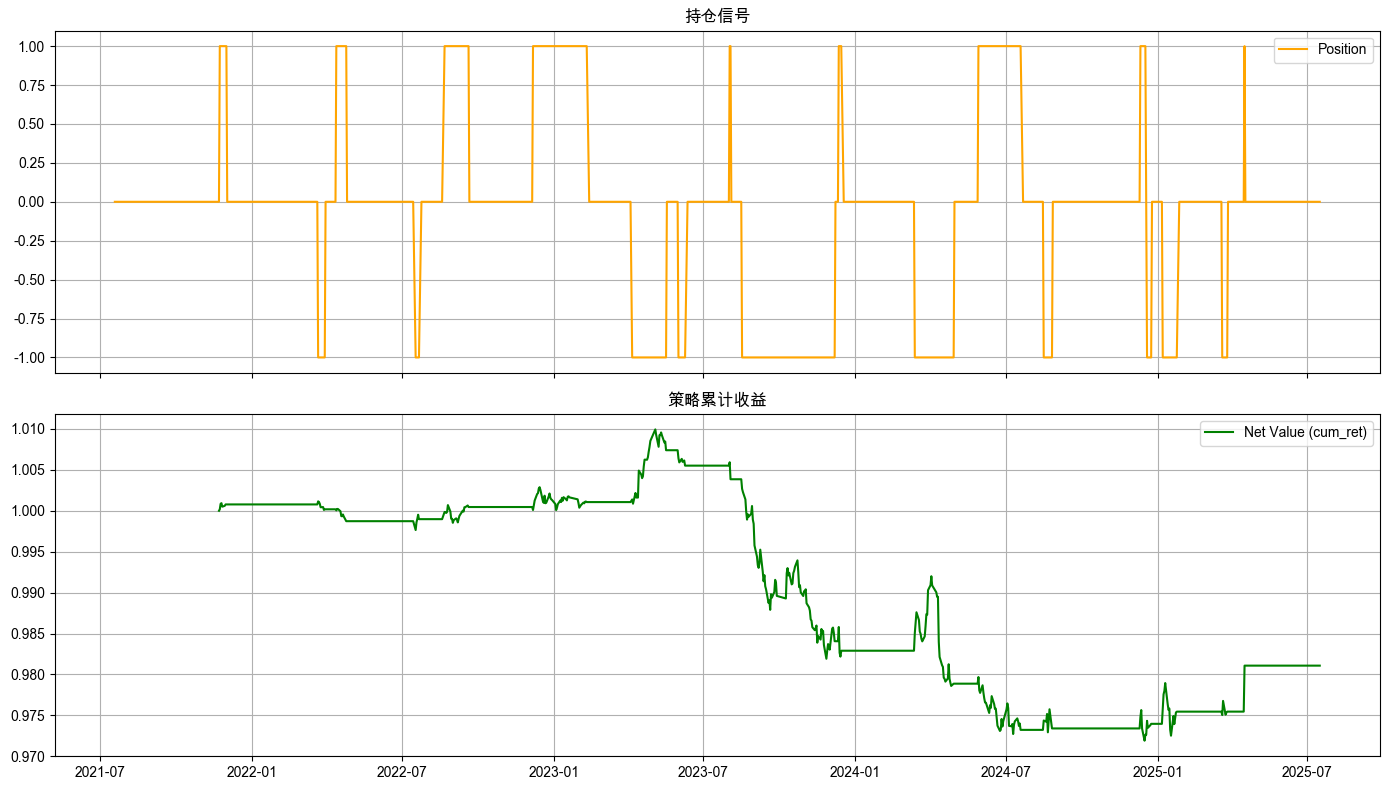

,日期,螺纹钢主连_收盘价,焦煤主连_收盘价,焦炭主连_收盘价,铁矿石主连_收盘价,热卷主连_收盘价,datetime,beta_kalman,spread,spread_mean,...,beta_vol,signal,frozen_beta,z_adj,position,ret_y,ret_x,combo_ret,cum_ret,cum_return
0,2021-07-19,5568,2040.5,2662.5,1225.0,5926,2021-07-19,0.999912,-621.766385,NaN,...,NaN,0,NaN,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN
1,2021-07-20,5601,2074.0,2738.0,1233.0,5968,2021-07-20,0.999824,-663.517335,NaN,...,NaN,0,NaN,NaN,0.0,0.016418,0.016418,NaN,NaN,NaN
2,2021-07-21,5561,2090.0,2736.0,1174.0,5918,2021-07-21,0.999737,-645.281753,NaN,...,NaN,0,NaN,NaN,0.0,0.007715,0.007715,NaN,NaN,NaN
3,2021-07-22,5648,2085.0,2737.5,1138.0,5947,2021-07-22,0.999651,-651.543266,NaN,...,NaN,0,NaN,NaN,0.0,-0.002392,-0.002392,NaN,NaN,NaN
4,2021-07-23,5671,2115.5,2769.5,1124.0,5968,2021-07-23,0.999565,-652.796288,NaN,...,NaN,0,NaN,NaN,0.0,0.014628,0.014628,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,2025-07-10,3123,897.0,1497.0,763.5,3262,2025-07-10,0.897011,-445.825477,-450.068170,...,0.003952,0,0.9098,0.238497,0.0,0.029260,0.029260,0.0,0.981074,-0.018921
964,2025-07-11,3133,913.0,1519.5,764.0,3273,2025-07-11,0.896816,-449.712069,-449.176752,...,0.003961,0,0.9098,-0.032716,0.0,0.017837,0.017837,0.0,0.981074,-0.018921
965,2025-07-14,3138,920.0,1525.0,766.5,3276,2025-07-14,0.896624,-447.351020,-448.004989,...,0.003969,0,0.9098,0.047848,0.0,0.007667,0.007667,0.0,0.981074,-0.018921
966,2025-07-15,3114,911.5,1514.0,767.0,3259,2025-07-15,0.896429,-445.693584,-447.905989,...,0.003975,0,0.9098,0.161931,0.0,-0.009239,-0.009239,-0.0,0.981074,-0.018921


In [46]:
calculate_pair_strategy_returns(df)

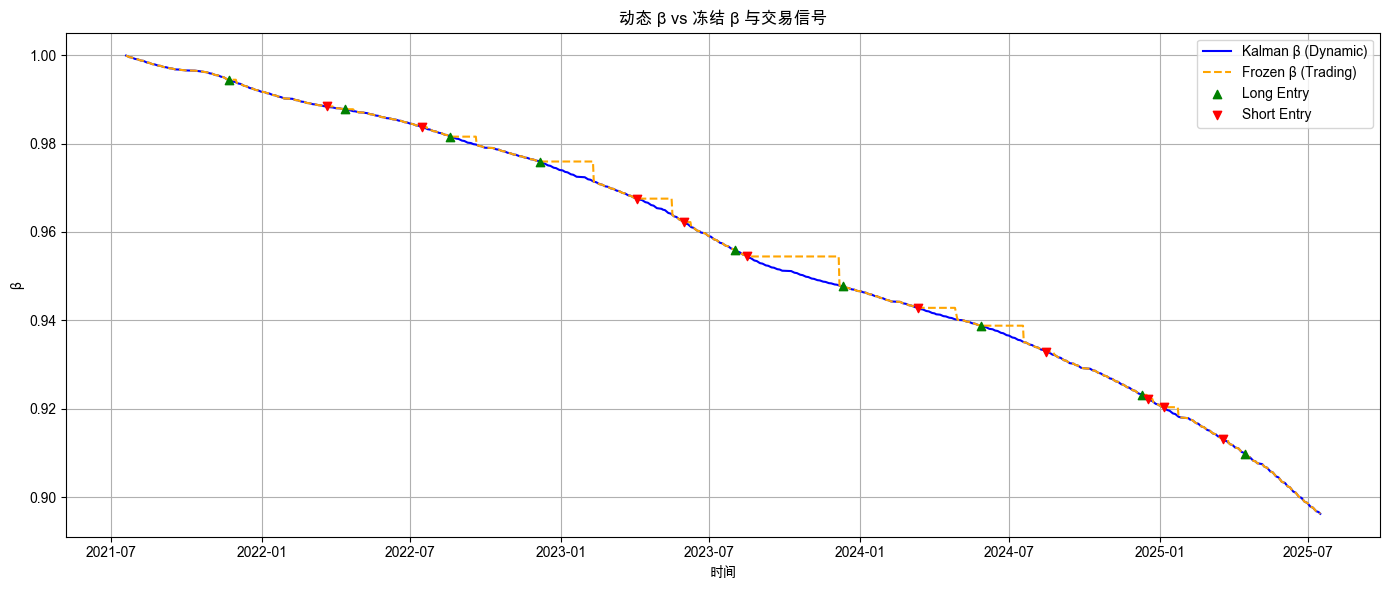

In [47]:
plot_beta_vs_frozen_with_signals(df)

In [10]:
# === 5. 生成交易信号 ===
df['signal'] = 0  # 1=做多，-1=做空，0=平仓或无信号
position = 0
entry_z = None
entry_time = None
hold_days = 0

for i in range(WIN, len(df)):
    z = df.loc[i, 'zscore']
    date = df.loc[i, 'datetime'].date()
    prev_date = df.loc[i - 1, 'datetime'].date()
    
    if position != 0 and date != prev_date:
        hold_days += 1

    if position == 0:
        if z < OPEN_L:
            df.loc[i, 'signal'] = 1
            position = 1
            entry_z = z
            entry_time = df.loc[i, 'datetime']
            hold_days = 0
        elif z > OPEN_H:
            df.loc[i, 'signal'] = -1
            position = -1
            entry_z = z
            entry_time = df.loc[i, 'datetime']
            hold_days = 0
    else:
        profit_cond = CLOSE_L < z < CLOSE_H
        stop_cond = (position == 1 and z < entry_z - STOP_SPREAD) or (position == -1 and z > entry_z + STOP_SPREAD)
        time_cond = hold_days >= MAX_HOLD
        if profit_cond or stop_cond or time_cond:
            df.loc[i, 'signal'] = 0
            position = 0
            entry_z = None
            entry_time = None
            hold_days = 0
        else:
            df.loc[i, 'signal'] = position

In [11]:
# === 1. 计算每日持仓（延迟一个bar建仓，避免未来函数） ===
df['position'] = df['signal'].shift(1).fillna(0)

# === 2. 计算组合收益 ===
# 组合收益 = Y头寸收益 - beta * X头寸收益
df['ret_y'] = df['焦煤主连_收盘价'].pct_change().fillna(0)
df['ret_x'] = df['焦炭主连_收盘价'].pct_change().fillna(0)
df['combo_ret'] = df['position'] * (df['ret_y'] - df['beta'] * df['ret_x'])

# === 3. 计算累计收益 ===
df['cum_ret'] = (1 + df['combo_ret']).cumprod()

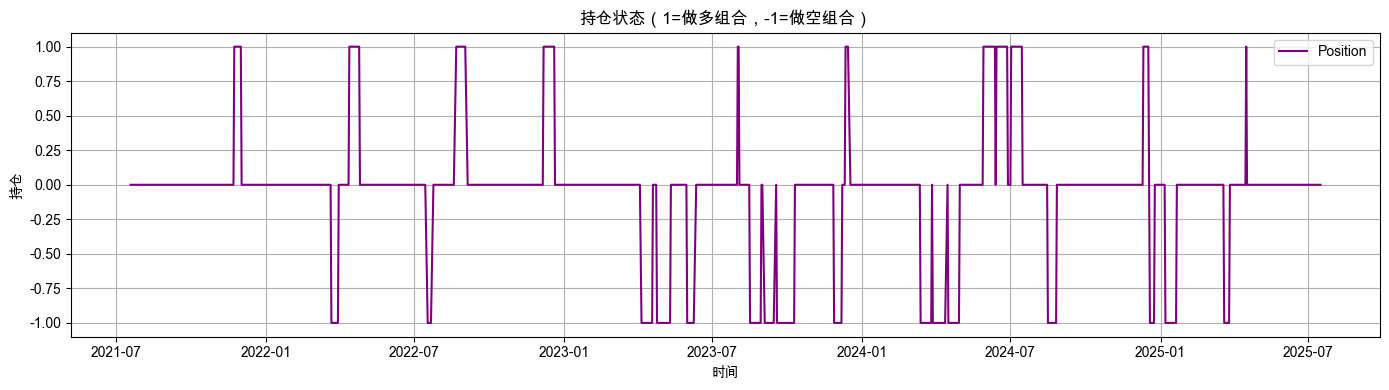

In [12]:
plt.figure(figsize=(14,4))
plt.plot(df['datetime'], df['position'], label="Position", color='purple')
plt.title("持仓状态（1=做多组合，-1=做空组合）")
plt.xlabel("时间")
plt.ylabel("持仓")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

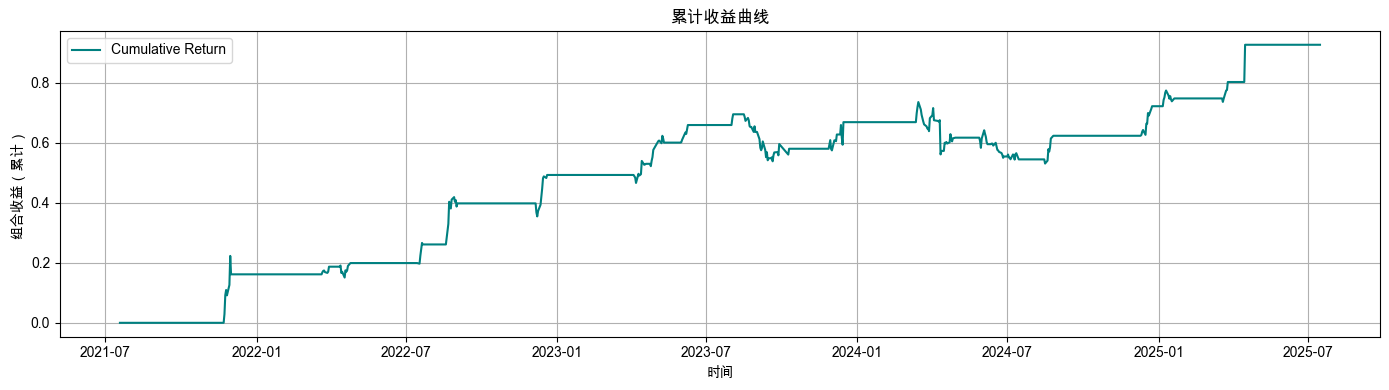

In [13]:
df['cum_ret'] = (1 + df['combo_ret']).cumprod()
df['cum_ret'] = df['cum_ret'] / df['cum_ret'].iloc[WIN] - 1

plt.figure(figsize=(14,4))
plt.plot(df['datetime'], df['cum_ret'], label="Cumulative Return", color='teal')
plt.title("累计收益曲线")
plt.xlabel("时间")
plt.ylabel("组合收益（累计）")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
data_path = "期货收盘价.xlsx"
residual_dir = "residual_plots"
zscore_dir = "zscore_plots"

#文件夹保存
os.makedirs(residual_dir, exist_ok=True)
os.makedirs(zscore_dir, exist_ok=True)

#读数据
df = pd.read_excel(data_path)
df = df.dropna().reset_index(drop=True)

#识别日期
date_col = [col for col in df.columns if '日期' in str(col)][0]
df[date_col] = pd.to_datetime(df[date_col])
price_cols = [col for col in df.columns if col != date_col]

#协整检验
def engle_granger_with_zscore(series1, series2):
    X = sm.add_constant(series1)
    model = sm.OLS(series2, X).fit()
    beta = model.params[1]
    residuals = model.resid

    #z-score标准化
    mu = residuals.mean()
    sigma = residuals.std()
    zscore = (residuals - mu) / sigma

    #ADF检验
    adf_stat, p_value, _, _, crit_vals, _ = adfuller(residuals)

    return {
        'beta': beta,
        'residuals': residuals,
        'zscore': zscore,
        'ADF统计量': adf_stat,
        'p值': p_value,
        '5%临界值': crit_vals['5%'],
        '是否协整(5%)': p_value < 0.05
    }

#循环
results = []

for col1, col2 in combinations(price_cols, 2):
    test = engle_granger_with_zscore(df[col1], df[col2])
    
    result = {
        '标的1': col1,
        '标的2': col2,
        'ADF统计量': test['ADF统计量'],
        'p值': test['p值'],
        'beta': test['beta'],
        '是否协整(5%)': test['是否协整(5%)']
    }
    results.append(result)

    # 残差图
    plt.figure(figsize=(10, 4))
    plt.plot(df[date_col], test['residuals'], label='残差')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"{col1} & {col2} 残差时间序列")
    plt.xlabel("日期")
    plt.ylabel("残差")
    plt.tight_layout()
    plt.savefig(f"{residual_dir}/残差_{col1}_{col2}.png")
    plt.close()

    # z-score 图
    plt.figure(figsize=(10, 4))
    plt.plot(df[date_col], test['zscore'], label='z-score')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axhline(2, color='red', linestyle='--')
    plt.axhline(-2, color='red', linestyle='--')
    plt.axhline(1, color='gray', linestyle=':')
    plt.axhline(-1, color='gray', linestyle=':')
    plt.title(f"{col1} & {col2} Z-Score 时间序列")
    plt.xlabel("日期")
    plt.ylabel("z-score")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{zscore_dir}/zscore_{col1}_{col2}.png")
    plt.close()

#保存结果
result_df = pd.DataFrame(results)
result_df.to_excel("协整检验结果.xlsx", index=False)

print("搞定")

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_87442/1980256588.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_87442/1980256588.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_87442/1980256588.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bet

搞定
